Imports

In [1]:
import joblib
import pathlib
from pprint import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from tqdm.auto import tqdm

warnings.simplefilter('ignore')

Create directories

In [2]:
plots_directory = pathlib.Path('plots')
plots_directory.mkdir(exist_ok=True)

models_directory = pathlib.Path('models')
models_directory.mkdir(exist_ok=True)

Read data

In [3]:
data = pd.read_csv('sensor_data.csv')
data.head()

,sr01,sr02,sr03,sr04,sr05,sr06,sr07,sr08,sr09,sr10,sr11,sr12,sr13,sr14,sr15,Discount,Repair,Scrap
0,77.544394,56.965071,15.603980,62.036615,83.603980,26.536272,78.819800,89.399870,8.356180,23.887907,90.896753,30.264493,77.512068,56.324794,101.084627,0,0,0
1,79.515133,57.636860,16.193504,61.896830,84.193504,23.342544,79.418817,91.592610,8.324448,25.068998,94.318870,26.198744,75.096502,54.269681,94.406536,1,0,0
2,78.807933,58.441762,17.304108,62.887095,85.304108,26.307873,79.720170,90.112075,8.200048,23.506052,92.319848,28.019432,78.237226,58.416269,99.450307,0,0,0
3,80.439316,58.209413,17.807938,64.278430,85.807938,27.354345,78.299032,92.649890,6.506277,22.768627,90.543946,28.815930,77.893412,56.016349,98.443900,0,0,0
4,77.717505,57.237781,16.614543,63.211944,84.614543,25.241739,78.022808,91.204471,8.621024,23.805275,93.621301,28.982012,75.025446,53.464343,95.099476,1,0,0


Get *baseline* defect rates

In [4]:
defects = [
    'Discount', 
    'Repair',
    'Scrap',
]

defect_rates = {}
for defect in defects:
    defect_rate = data[defect].mean()
    defect_rates[defect] = defect_rate
    print(f' - {defect}: {defect_rate: .2%}')

 - Discount:  10.58%
 - Repair:  12.59%
 - Scrap:  3.86%


Simulate reductions in defect rates 

In [5]:
production = 900000
good_demand = 846312

sensitivity_analysis = []
for scrap_reduction in np.arange(0.0, 1.01, 0.1):
    for repair_reduction in np.arange(0.0, 1.01, 0.1):
        for discount_reduction in np.arange(0.0, 1.01, 0.1):

            scrap_products = production*defect_rates['Scrap']
            repair_products = production*defect_rates['Repair']
            discount_products = production*defect_rates['Discount']
            
            scrap_products = scrap_products*(1-scrap_reduction)
            repair_products = repair_products*(1-repair_reduction)
            discount_products = discount_products*(1-discount_reduction)
            
            good_products = production - scrap_products - repair_products - discount_products
            if good_products > good_demand:
                delta = good_products - good_demand
                discount_products += delta
                good_products = good_demand
            
            revenue = 100*good_products + 75*discount_products + 75*repair_products
            costs = 50*production + 5*repair_products
            
            profit = (revenue - costs)/1000

            sensitivity_analysis.append([
                100*scrap_reduction,
                100*repair_reduction,
                100*discount_reduction,
                profit,
            ])

sensitivity_analysis = pd.DataFrame(
    sensitivity_analysis,
    columns=[
        'scrap_reduction_percent',
        'repair_reduction_percent',
        'discount_reduction_percent',
        'profit',
    ]
)

sensitivity_analysis[[
    'scrap_reduction_percent', 'repair_reduction_percent', 'discount_reduction_percent'
]] = sensitivity_analysis[[
    'scrap_reduction_percent', 'repair_reduction_percent', 'discount_reduction_percent'
]].round(2)

Run regression on simulation results.

In [6]:
formula = 'profit ~ scrap_reduction_percent * repair_reduction_percent * discount_reduction_percent'

reg = smf.ols(formula=formula, data=sensitivity_analysis).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 4.768e+04
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:49:28   Log-Likelihood:                -8066.2
No. Observations:                1331   AIC:                         1.615e+04
Df Residuals:                    1323   BIC:                         1.619e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    3.573e+04     18.665   1914.251      0.000    3.57e+04    3.58e+04
scrap_reduction_percent                                                        34.2150      0.315    108.450      0.000      33.596      34.834
repair_reduction_percent                                                       34.3746      0.315    108.956      0.000      33.756      34.993
scrap_reduction_percent:repair_reduction_percent                                0.0243      0.005      4.553      0.000       0.014       0.035
discount_reduction_percent                                                     24.1792      0.315     76.640      0.000      23.560      24.798
scrap_reduction_percent:discount_reduction_percent                              0.0263      0.005      4.930      0.000       0.016       0.037
repair_reduction_percent:discount_reduction_percent                            -0.0096      0.005     -1.796      0.073      -0.020       0.001
scrap_reduction_percent:repair_reduction_percent:discount_reduction_percent    -0.0011   9.01e-05    -12.039      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      611.705   Durbin-Watson:                   0.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5631.937
Skew:                          -1.905   Prob(JB):                         0.00
Kurtosis:                      12.329   Cond. No.                     1.36e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Look at sensor correlations

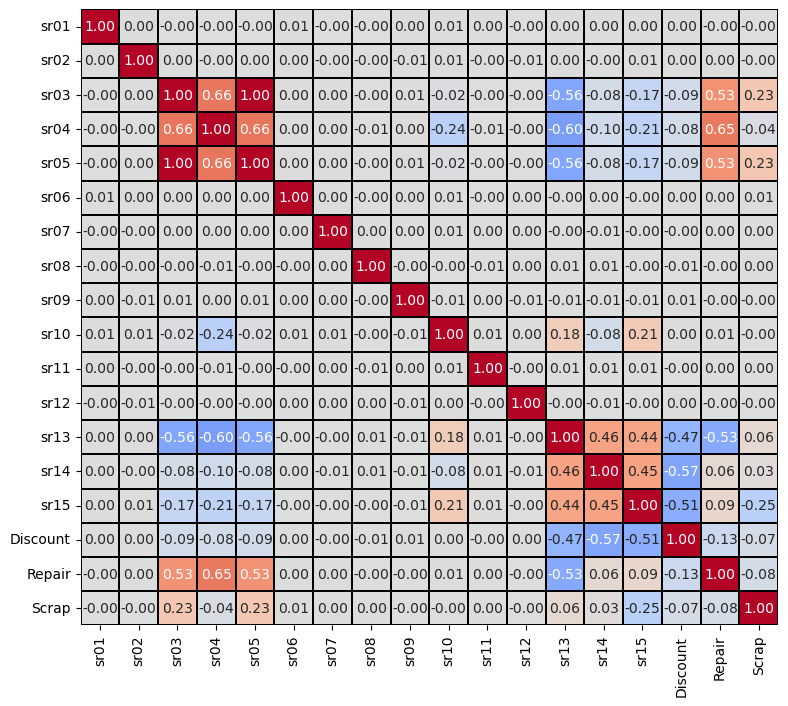

In [7]:
corr = data.corr()

fig, ax = plt.subplots(1, 1, figsize=(9, 8))

sns.heatmap(
    corr,
    cmap='coolwarm',
    vmin=-1.0,
    vmax=1.0,
    linewidths=0.1,
    linecolor='k',
    cbar=False,
    annot=True,
    fmt='.2f',
)
plt.savefig('plots/correlation_heatmap.pdf', bbox_inches='tight')
plt.show()

Define features and targets

In [8]:
features = [col for col in data.columns if (col.startswith('sr') and (col != 'sr05'))]
targets = ['Discount', 'Repair', 'Scrap']

Fit models for all defect categories.

In [9]:
for target in targets:
    model_filepath = pathlib.Path(
        models_directory,
        f'RF-{target}.model',
    )

    X_train, X_test, y_train, y_test = train_test_split(
        data[features], 
        data[target], 
        test_size=0.25, 
        random_state=42,
        stratify=data[target],
    )
    
    if not model_filepath.exists():
        print(f' - Fitting RF for {target}')
        
        base_RF = RandomForestClassifier(random_state=42)
        
        params = {
            'n_estimators': [25, 50],
            'max_depth': [2, 4, 6, 8, 10],
            'criterion': ['gini', 'entropy'],
            'class_weight': ['balanced', 'balanced_subsample'],
        }
        
        GS = GridSearchCV(
            base_RF, 
            params,
            n_jobs=4,
        ).fit(X_train, y_train)

        with open(model_filepath, 'wb') as fout:
            joblib.dump(GS, fout)
    else:
        print(f' - Reading RF for {target}')
        
        with open(model_filepath, 'rb') as fin:
            GS = joblib.load(fin)
        
    for param, val in GS.best_params_.items():
        print(f'    - {param}: {val}')
        
    accuracy = GS.best_estimator_.score(X_test, y_test)
    print(f'    - Accuracy: {accuracy: .2%}')

 - Reading RF for Discount
    - class_weight: balanced
    - criterion: entropy
    - max_depth: 10
    - n_estimators: 25
    - Accuracy:  98.65%
 - Reading RF for Repair
    - class_weight: balanced
    - criterion: entropy
    - max_depth: 10
    - n_estimators: 25
    - Accuracy:  98.13%
 - Reading RF for Scrap
    - class_weight: balanced
    - criterion: entropy
    - max_depth: 10
    - n_estimators: 25
    - Accuracy:  98.46%


Get repair model feature importances

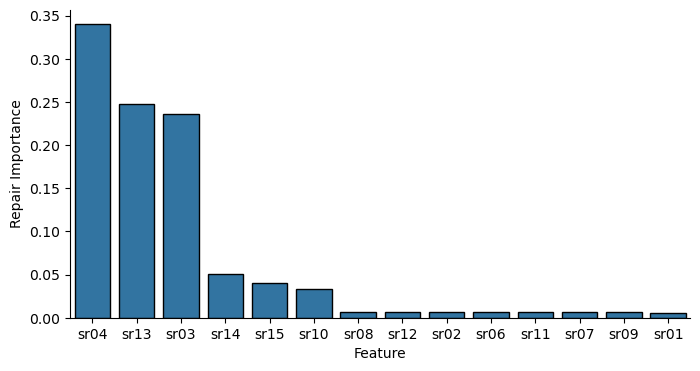

In [10]:
model_filepath = pathlib.Path(
    models_directory,
    'RF-Repair.model',
)

with open(model_filepath, 'rb') as fin:
    GS = joblib.load(fin)

best_repair_model = GS.best_estimator_

repair_importances = []
for feature, importance in zip(features, best_repair_model.feature_importances_):
    repair_importances.append([feature, importance])

repair_importances = pd.DataFrame(
    repair_importances, 
    columns=['Feature', 'Repair Importance'],
).sort_values(
    'Repair Importance',
    ascending=False,
)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.barplot(
    data=repair_importances,
    x='Feature',
    y='Repair Importance',
    edgecolor='k',
)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

Get scrap model feature importances

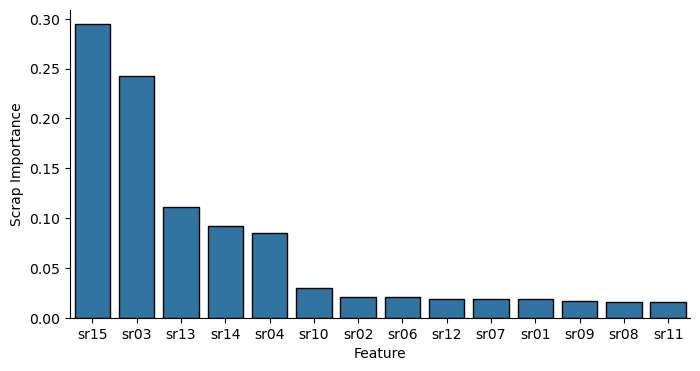

In [11]:
model_filepath = pathlib.Path(
    models_directory,
    'RF-Scrap.model',
)

with open(model_filepath, 'rb') as fin:
    GS = joblib.load(fin)

best_scrap_model = GS.best_estimator_

scrap_importances = []
for feature, importance in zip(features, best_scrap_model.feature_importances_):
    scrap_importances.append([feature, importance])

scrap_importances = pd.DataFrame(
    scrap_importances, 
    columns=['Feature', 'Scrap Importance'],
).sort_values(
    'Scrap Importance',
    ascending=False,
)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.barplot(
    data=scrap_importances,
    x='Feature',
    y='Scrap Importance',
    edgecolor='k',
)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

Compare both sets of feature importances.

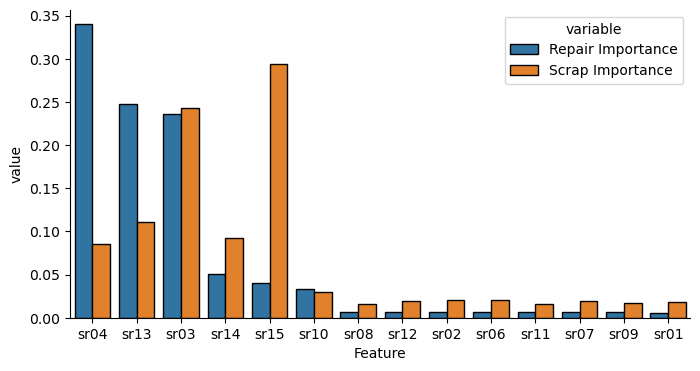

In [12]:
combined_importances = repair_importances.merge(
    scrap_importances
).melt(
    id_vars='Feature'
)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.barplot(
    data=combined_importances,
    x='Feature',
    y='value',
    edgecolor='k',
    hue='variable',
)
ax.spines[['right', 'top']].set_visible(False)

plt.show()